## VK parsed data processing

In [45]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from collections import Counter

sns.set()
%matplotlib inline

In [42]:
def moviesmusic(raw):
    if raw is not np.nan:
        raw = re.sub('[":«»]', '', raw)
        raw = raw.lower()
        temp = []
        for i in re.split(r'[,\;]+', raw):
            i = re.sub(r'\(.+\)', '', i)
            if i != ' ' and not bool(re.match(r'^\d+|^\s+', i.strip())):
                temp.append(i.strip())
            else:
                continue
        return temp


def bdays(raw, type='day'):
    raw = str(raw)
    if raw == np.nan or raw == 'nan':
        return np.nan
    if type == 'day':
        return np.int64(raw.split('.')[0].strip())
    elif len(raw.split('.')) == 2 and type == 'month':
        return np.int64(raw.split('.')[1].strip())
    elif len(raw.split('.')) == 3 and type == 'month':
        return np.int64(raw.split('.')[1].strip())
    elif len(raw.split('.')) == 3 and type == 'year':
        return np.int64(raw.split('.')[2].strip())
    else:
        return np.nan


def adopttocal(art):
    #########################################################################
    # function builds dictionary of Counters.                               #
    # key is the item and the value is counter in which                     #
    # it counts all the occurences with other items                         #
    # then, getting the item(art, name, or whatever) by key                 #
    # you will get the Counter (sorted by number of occurences eventually)  #
    # with all the recommended items                                        #
    # NOTE: to collect this dict it requires the big datasets               #
    #########################################################################
    for item in art:
        if item in catalog.keys():
            temp = catalog[item]
            for item_2 in art:
                if item_2 != item: # exclude self counting
                    temp[item_2] += 1
        else:
            temp = Counter()
            for item_2 in art:
                if item_2 != item: # exclude self counting
                    temp[item_2] += 1
            catalog[item] = temp

In [36]:
df = pd.read_csv('vk.csv', sep=';', header=None)
df.columns = ['uid', 'name', 'surname', 'sex', 'country', 'city', 'bday', 'music', 'movies']
df['sex'] = df['sex'].astype(dtype='Int64')

### Music analyse block

In [37]:
df['music'] = df['music'].apply(lambda x: moviesmusic(x))
df2 = df[['sex', 'music']].dropna()
df2 = df2.explode('music', ignore_index=True)

In [38]:
df2['music'].value_counts().head(20)

рок             4535
кино            3739
ария            3415
сплин           3356
linkin park     3056
ддт             3036
queen           2911
metallica       2820
классика        2634
muse            2598
house           2598
nightwish       2575
pink floyd      2480
rammstein       2439
nirvana         2256
разная          2226
мельница        2150
джаз            2013
depeche mode    1951
trance          1930
Name: music, dtype: int64

In [39]:
groups = ['pink floyd']

df2 = df2[df2['music'].isin(groups)]
print('Groups: {}\nNumber of records: {}\n'.format(groups, df2.shape[0]))

df2 = df2.groupby('sex', as_index=False).count()
df2['sex'] = df2['sex'].map({2: 'male', 1: 'female'})
df2['music'] = df2['music'] / df2['music'].sum() * 100
df2

Groups: ['pink floyd']
Number of records: 2480



,sex,music
0,female,23.709677
1,male,76.290323


In [57]:
df2 = df['movies'].dropna().apply(lambda x: moviesmusic(x))
df2['movies'] = df2.explode('movies')

In [69]:
top_movies = df2['movies'].value_counts().head(20)

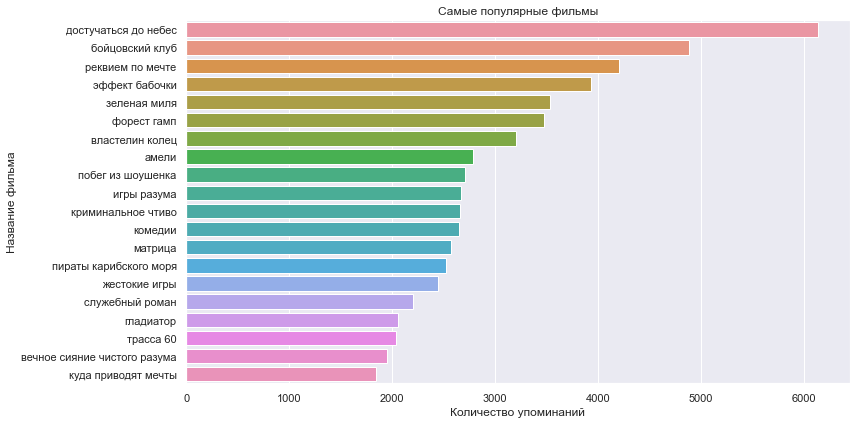

In [95]:
plt.figure(figsize=(12, 6))
sns.barplot(orient='h', x=top_movies.values, y=top_movies.index)
plt.title('Самые популярные фильмы')
plt.xlabel('Количество упоминаний')
plt.ylabel('Название фильма')
plt.tight_layout()
plt.savefig('top_movies.jpg');

In [46]:
catalog = {}
df2 = df['movies'].dropna().apply(lambda x: moviesmusic(x))
df2.apply(adopttocal)

0          None
5          None
9          None
19         None
21         None
           ... 
2012342    None
2012347    None
2012351    None
2012384    None
2012397    None
Name: movies, Length: 149506, dtype: object

In [55]:
rec_number = 10
art_number = 9
print('\nTop {} recommended items for '.format(str(rec_number)), list(catalog.keys())[art_number], ':')
# print('\n', catalog[list(catalog.keys())[5]].most_common(5))
for art, _ in catalog[list(catalog.keys())[art_number]].most_common(rec_number):
    print(art)


Top 10 recommended items for  луна :
игры разума
остров
достучаться до небес
полночь в париже
чужой
день сурка
гаттака
назад в будущее
револьвер
криминальное чтиво


In [89]:
df['year'] = df['bday'].apply(lambda x: bdays(x, type='year'))
df2 = df[['year', 'sex']].dropna()
df2['age'] = 2020 - df2['year'].astype(np.int64)
df2 = df2[df2['age'] < 70]
df2['sex'] = df2['sex'].apply(lambda x: 'муж' if x == 2 else 'жен')
df2.head()

,year,sex,age
0,1984.0,муж,36
12,1982.0,муж,38
16,1985.0,муж,35
17,1986.0,муж,34
19,1986.0,муж,34


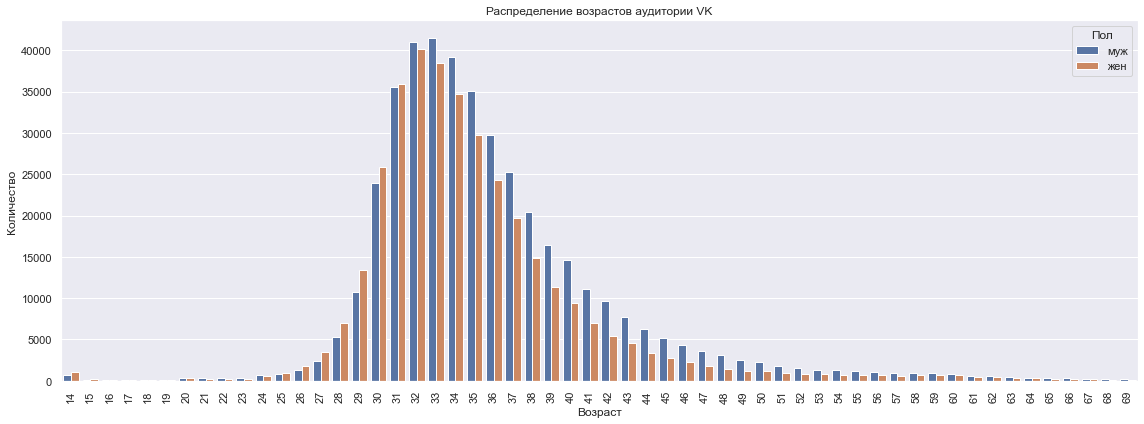

In [93]:
plt.figure(figsize=(16, 6))
plt.xticks(rotation=90)
sns.countplot(data=df2, x='age', hue='sex')
plt.title('Распределение возрастов аудитории VK')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.legend(title='Пол')
plt.tight_layout()
plt.savefig('sex_dist.jpg')